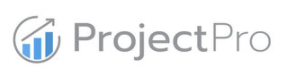

# ProjectPro - Ensemble Models
Author: Anish Mahapatra

<b>Aim:</b> <br/>The purpose of this notebook is to understand Ensemble Models end to end.


<a name="0"></a>
## Table of Contents

1 [What is Ensemble Learning](#1) <br/>
2 [Types of Ensemble Learning](#2) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 [Max Voting](#2.1) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 [Averaging](#2.2) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3 [Weighted Average](#2.3) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4 [Bagging](#2.4) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.5 [Boosting](#2.5) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.6 [Stacking](#2.6) <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.7 [Blending](#2.7) <br/>

<a name="1"></a>
## 1 Types of Ensemble Models
Back to [Table of Contents](#0)

---

Head to https://www.dezyre.com/


<a name="2"></a>
## 2 What is Ensemble Modelling?
Back to [Table of Contents](#0)

---


<a name="2.0"></a>
### 2.0 Preprocessing & Modelling
Back to [Table of Contents](#0)

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading the file onto Google Colab from GitHub using pandas library
titanicTrainDf = pd.read_csv("https://raw.githubusercontent.com/anishmahapatra/Ensemble-Learning/main/titanic-dataset-train.csv")
titanicTestDf = pd.read_csv("https://raw.githubusercontent.com/anishmahapatra/Ensemble-Learning/main/titanic-dataset-test.csv")

In [ ]:
train = titanicTrainDf.copy(deep = True)
predict = titanicTestDf.copy(deep = True)

In [ ]:
# we will have to apply our feature engineering to both sets
both_datasets = [train, predict]

# getting an idea of what we're dealing with
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [ ]:
train.append(predict, sort=False).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


Let's handle the null values in the Age, Cabin, Embarked, and Fare columns.



In [ ]:
""" values taken from the training set, which needn't be changed in the loop """

# ports where people boarded
embark = train[['Embarked', 'PassengerId']] \
    .groupby(['Embarked']) \
    .count() \
    .rename(columns={'PassengerId': 'PassengerCount'})
embark = embark.PassengerCount.to_dict() 

# calculating the median fare per passenger class
fare_medians = train[['Pclass', 'Fare']] \
    .groupby('Pclass') \
    .median() \
    .to_dict()['Fare']

In [ ]:
# looping through both train and predict
for df in both_datasets:
    
    """ age """
    # create a random distribution of age based on the dataframe's stats
    mu, sigma, n = train.Age.mean(), train.Age.std(), df.Age.isnull().sum()
    normal_distr = np.random.normal(mu, sigma, n)
    
    # impute it on the missing values
    df.Age.loc[np.isnan(df.Age)] = normal_distr.astype(int)
    
    """ cabin """
    # convert Cabin to boolean (passenger has cabin y/n)
    df.Cabin = df.Cabin.apply(lambda x: 1 if not pd.isnull(x) else 0)
    
    """ embarked """
    # only two missing values, so let's just take the most common port
    embark_imputes = max(embark, key=embark.get)
    
    # impute
    df.Embarked = df.Embarked.fillna(embark_imputes)
    
    """ fare """    
    # impute by mapping Pclass to the previously defined dictionary
    df.Fare = df.Fare.fillna(df.Pclass.map(fare_medians))

In [ ]:
train.append(predict, sort=False).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   int64  
 11  Embarked     1309 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 132.9+ KB


The only NaN values remaining are our missing predictions. The rest looks good!

Feature engineering & Cleansing

In [ ]:
import re

def get_title(name):
    title = re.search(' ([A-Za-z]+)\.', name)
    if title: return title.group(1)

def get_int_age_group(age):
    age_group = 'elderly'
    if age <= 50: age_group = 'old_adult'
    if age <= 40: age_group = 'mid_adult'
    if age <= 30: age_group = 'young_adult'
    if age <= 18: age_group = 'teenager'
    if age <= 9 : age_group = 'child'
        
    return age_group

In [ ]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
5,6,0,3,"Moran, Mr. James",male,47.0,0,0,330877,8.4583,0,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,1,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,0,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C


In [ ]:
# looping through both train and predict
for df in both_datasets:
    
    """ name -> title """
    # extracting the title with regular expressions where there is one
    df['Title'] = df.Name.apply(get_title)
    
    # processing the extract titled
    df.Title = df.Title.replace({
        'Mlle': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs'
    })
    
    """ sex """
    df.Sex = df.Sex.map({
        'male'  : 0,
        'female': 1
    })
    
    """ age """
    # convert ages to categories
    df.Age = df.Age.apply(get_int_age_group)
    
    """ traveled alone """
    df['TraveledAlone'] = df.apply(lambda row: 1 if row['SibSp'] + row['Parch'] == 0 else 0, axis=1)

The fare is going to be based on the training set quartiles, so we need to do it outside of the loop.

In [ ]:
# we want categories
labels = ['cheap', 'economy', 'business', 'first']

""" fare """
# quartiles based on the training set
fare_categorical_series, bins = pd.qcut(train['Fare'], q=4, retbins=True, labels=labels)

# putting the series in the training set
train['FareCategorical'] = fare_categorical_series

# cutting the predict set based on the bins derived from the training set
predict['FareCategorical'] = pd.cut(predict.Fare, bins=bins, labels=labels, include_lowest=True)

One more pass for the Title.

In [ ]:
 # any title that appears less than 4% of the time in the training set is treated as rare
titles = train[['Title', 'PassengerId']] \
    .groupby(['Title'], as_index=False) \
    .count() \
    .rename(columns={'PassengerId': 'Count'})

titles['Common'] = titles.Count / titles.Count.sum() > 0.04
common_titles = list(titles.loc[titles.Common == True].Title.values)

# looping over both train and predict datasets
for df in both_datasets:
    
    """ title """    
    # map the common titles to a number
    df.Title = df.apply(lambda row: 'Rare' if row['Title'] not in common_titles else row['Title'], axis=1)


Dummifying

In [ ]:
def dummify(df, column_to_dummify):

    dummies = pd.get_dummies(df[column_to_dummify], prefix=column_to_dummify)
    df = pd.concat([df, dummies], axis=1)
    df.drop(column_to_dummify, axis=1, inplace=True)

    return df

In [ ]:
cols_to_dummify = ['Pclass', 'Embarked', 'Age', 'FareCategorical', 'Title']

for col in cols_to_dummify:
    train = dummify(train, col)
    predict = dummify(predict, col)

In [ ]:
train.head()

,PassengerId,Survived,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,TraveledAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_child,Age_elderly,Age_mid_adult,Age_old_adult,Age_teenager,Age_young_adult,FareCategorical_cheap,FareCategorical_economy,FareCategorical_business,FareCategorical_first,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,"Braund, Mr. Owen Harris",0,1,0,A/5 21171,7.2500,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,PC 17599,71.2833,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",1,0,0,STON/O2. 3101282,7.9250,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,113803,53.1000,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,5,0,"Allen, Mr. William Henry",0,0,0,373450,8.0500,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


Feature selection

In [ ]:
# extracting the passenger column from the submission 
# dataset for later use during our submission
passenger_id = predict.PassengerId

# selection
unwanted_features = ['PassengerId', 'Name', 'Ticket', 'Fare', 'SibSp', 'Parch']

# dropping selection
train   = train.drop(unwanted_features, axis=1)
predict = predict.drop(unwanted_features, axis=1)

In [ ]:
train.head(10)

,Survived,Sex,Cabin,TraveledAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_child,Age_elderly,Age_mid_adult,Age_old_adult,Age_teenager,Age_young_adult,FareCategorical_cheap,FareCategorical_economy,FareCategorical_business,FareCategorical_first,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
1,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
3,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
5,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
6,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
7,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
8,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
9,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


Train/Test Split

In [ ]:
# manual parameters
TEST_RATIO = 0.2
RANDOM_SEED = 42

In [ ]:
features = train.drop('Survived', axis=1).values
labels = train.Survived.values

# splitting our 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=TEST_RATIO,
                                                    random_state=RANDOM_SEED)

In [ ]:
def training_accuracy_report(GridSearchCv_classifier):
    print(
f"""Best parameters: 
    {GridSearchCv_classifier.best_params_}
    
Best estimator:
    {GridSearchCv_classifier.best_estimator_}
    
Mean cross-validated score of the best_estimator on the training set:
    {GridSearchCv_classifier.best_score_*100:,.2f}%    
""")


<a name="2.1.1"></a>
#### 2.1.1 Support Vector Machine
Back to [Table of Contents](#0)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# parameter grid for our search
parameters = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4], # only applies to kernel == 'poly'
    'kernel': ('linear', 'rbf', 'poly')
}

# initiating our support vector machine
svm = svm.SVC(gamma='scale',
              probability=True,
              random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=svm,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_svm = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_svm)

Best parameters: 
    {'C': 1, 'degree': 2, 'kernel': 'rbf'}
    
Best estimator:
    SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
    
Mean cross-validated score of the best_estimator on the training set:
    82.16%    



In [ ]:
# for accuracy calculation
from sklearn import metrics

# make predictions
y_pred_svm = best_svm.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_svm)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy*100:,.2f}%')

Accuracy on the test set: 78.77%


<a name="2.1.2"></a>
#### 2.1.2 Gradient Boosted Trees
Back to [Table of Contents](#0)

In [ ]:
import xgboost as xgb

# parameter grid for our search
parameters = {
    'min_child_weight': [5, 6, 7],
    'gamma': [0, 0.2],
    'colsample_bytree': [0, 0.2, 0.4],
    'max_depth': [3, 4, 5]
}

# initiating our gradient boosted tree
xgb = xgb.XGBClassifier(objective='reg:squarederror', random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=xgb,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_xgb = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_xgb)

Best parameters: 
    {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 6}
    
Best estimator:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
    
Mean cross-validated score of the best_estimator on the training set:
    81.74%    



In [ ]:
# make predictions
y_pred_xgb = best_xgb.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_xgb)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy*100:,.2f}%')

Accuracy on the test set: 79.89%


<a name="2.1.3"></a>
#### 2.1.3 Random Forest
Back to [Table of Contents](#0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# parameter grid for our search
parameters = {
    'n_estimators': [75, 100, 125, ],
    'max_depth': [10, 50, 100, None],
    'max_features': [0.5, 1],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [2, 3]
}

rfc = RandomForestClassifier(criterion='gini',
                             bootstrap=False,
                             random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=rfc,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_rfc = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_rfc)

Best parameters: 
    {'max_depth': 50, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
    
Best estimator:
    RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
    
Mean cross-validated score of the best_estimator on the training set:
    82.45%    



In [ ]:
from sklearn.ensemble import VotingClassifier

# make predictions
y_pred_rfc = best_rfc.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rfc)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy*100:,.2f}%')

Accuracy on the test set: 78.77%


<a name="2.1"></a>
### 2.1 Max Voting
Back to [Table of Contents](#0)

In [ ]:
# ProjectPro - https://www.dezyre.com/
# 3.1.1 - Max Voting
# Using sklearn.ensemble.VotingClassifier to perform Max Voting
vc = VotingClassifier(
    
    # Support Vector Machine, XGBoost and Random Forest Classifier
    estimators=[
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('rfc', best_rfc)
    ], 
    
    # soft = Probabilities are taken into account
    # hard = Only the outcome counts
    voting='soft',
    
    # You can add weights, if required
    weights=[1, 1, 1] 
    
)

# Fitting
vc = vc.fit(X_train, y_train)

In [ ]:
# accuracy on test set
y_pred_vc = vc.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_vc)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy*100:,.2f}%')

Accuracy on the test set: 79.89%


<a name="2.2"></a>
### 2.2 Averaging
Back to [Table of Contents](#0)

In [ ]:
# ProjectPro - https://www.dezyre.com/
# 3.1.2 - Averaging

# Results of XGBoost
resultXGB = best_xgb.best_score_*100
print(f'XGBoost: {resultXGB:,.2f}%')

# Results of SVM
resultSVM = best_svm.best_score_*100
print(f'Support Vector Machine: {resultSVM:,.2f}%')

# Results of Random Forest
resultRFC = best_rfc.best_score_*100
print(f'Random Forest Classifier: {resultRFC:,.2f}%')

XGBoost: 81.74%
Support Vector Machine: 82.16%
Random Forest Classifier: 82.45%


In [ ]:
# Averaging the results of the three models
resultAverage = (resultXGB + resultSVM + resultRFC) / 3
print(f'Ensemble Model - Averaging: {resultXGB:,.2f}%')

Ensemble Model - Averaging: 81.74%


<a name="2.3"></a>
### 2.3 Weighted Average
Back to [Table of Contents](#0)

In [ ]:
# ProjectPro - https://www.dezyre.com/
# 3.1.3 - Weighted Average Ensemble Model
# Weight assigned and Result for XGBoost
weightXGB = 0.3
resultXGB = best_xgb.best_score_*100
print(f'Weight for XGBoost: {weightXGB:,.1f}')
print(f'Result for XGBoost: {resultXGB:,.2f}%')

Weight for XGBoost: 0.3
Result for XGBoost: 81.74%


In [ ]:
# Weight assigned and Result for Support Vector Machine
weightSVM = 0.3
resultSVM = best_svm.best_score_*100
print(f'Weight for Support Vector Machine: {weightSVM:,.1f}')
print(f'Result for Support Vector Machine: {resultSVM:,.2f}%')

Weight for Support Vector Machine: 0.3
Result for Support Vector Machine: 82.16%


In [ ]:
# Weight assigned and Result for Random Forest Classifier
weightRFC = 0.4
resultRFC = best_rfc.best_score_*100
print(f'Weight for Random Forest Classifier: {weightRFC:,.1f}')
print(f'Result for Random Forest Classifier: {resultRFC:,.2f}%')

Weight for Random Forest Classifier: 0.4
Result for Random Forest Classifier: 82.45%


In [ ]:
# Calculating Weighted Average
resultWeightedAverage = ( weightXGB*resultXGB + weightSVM*resultSVM + weightRFC*resultRFC)
print(f'Result for Weighted Average: {resultWeightedAverage:,.2f}%')

Result for Weighted Average: 82.15%


<a name="2.4"></a>
### 2.4 Bagging - Processing
Back to [Table of Contents](#0)

In [ ]:
#@title Processing
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns

train = titanicTrainDf.copy(deep = True)
test = titanicTestDf.copy(deep = True)

## saving passenger id in advance in order to submit later. 
passengerid = test.PassengerId

## Replacing the null values in the Embarked column with the mode. 
train.Embarked.fillna("C", inplace=True)

## Concat train and test into a variable "all_data"
survivers = train.Survived

train.drop(["Survived"],axis=1, inplace=True)

all_data = pd.concat([train,test], ignore_index=False)

## Assign all the null values to N
all_data.Cabin.fillna("N", inplace=True)

all_data.Cabin = [i[0] for i in all_data.Cabin]

with_N = all_data[all_data.Cabin == "N"]

without_N = all_data[all_data.Cabin != "N"]

all_data.groupby("Cabin")['Fare'].mean().sort_values()

def cabin_estimator(i):
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a
    

##applying cabin estimator function. 
with_N['Cabin'] = with_N.Fare.apply(lambda x: cabin_estimator(x))

## getting back train. 
all_data = pd.concat([with_N, without_N], axis=0)

## PassengerId helps us separate train and test. 
all_data.sort_values(by = 'PassengerId', inplace=True)

## Separating train and test from all_data. 
train = all_data[:891]

test = all_data[891:]

# adding saved target variable with train. 
train['Survived'] = survivers

missing_value = test[(test.Pclass == 3) & (test.Embarked == "S") & (test.Sex == "male")].Fare.mean()
## replace the test.fare null values with test.fare mean
test.Fare.fillna(missing_value, inplace=True)

## dropping the three outliers where Fare is over $500 
train = train[train.Fare < 500]

# Placing 0 for female and 
# 1 for male in the "Sex" column. 
train['Sex'] = train.Sex.apply(lambda x: 0 if x == "female" else 1)
test['Sex'] = test.Sex.apply(lambda x: 0 if x == "female" else 1)

# Creating a new colomn with a 
train['name_length'] = [len(i) for i in train.Name]
test['name_length'] = [len(i) for i in test.Name]

def name_length_group(size):
    a = ''
    if (size <=20):
        a = 'short'
    elif (size <=35):
        a = 'medium'
    elif (size <=45):
        a = 'good'
    else:
        a = 'long'
    return a


train['nLength_group'] = train['name_length'].map(name_length_group)
test['nLength_group'] = test['name_length'].map(name_length_group)

## Here "map" is python's built-in function. 
## "map" function basically takes a function and 
## returns an iterable list/tuple or in this case series. 
## However,"map" can also be used like map(function) e.g. map(name_length_group) 
## or map(function, iterable{list, tuple}) e.g. map(name_length_group, train[feature]]). 
## However, here we don't need to use parameter("size") for name_length_group because when we 
## used the map function like ".map" with a series before dot, we are basically hinting that series 
## and the iterable. This is similar to .append approach in python. list.append(a) meaning applying append on list. 

## cuts the column by given bins based on the range of name_length
#group_names = ['short', 'medium', 'good', 'long']
#train['name_len_group'] = pd.cut(train['name_length'], bins = 4, labels=group_names)

## Title
## get the title from the name
train["title"] = [i.split('.')[0] for i in train.Name]
train["title"] = [i.split(',')[1] for i in train.title]
test["title"] = [i.split('.')[0] for i in test.Name]
test["title"]= [i.split(',')[1] for i in test.title]

#rare_title = ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col']
#train.Name = ['rare' for i in train.Name for j in rare_title if i == j]
## train Data
train["title"] = [i.replace('Ms', 'Miss') for i in train.title]
train["title"] = [i.replace('Mlle', 'Miss') for i in train.title]
train["title"] = [i.replace('Mme', 'Mrs') for i in train.title]
train["title"] = [i.replace('Dr', 'rare') for i in train.title]
train["title"] = [i.replace('Col', 'rare') for i in train.title]
train["title"] = [i.replace('Major', 'rare') for i in train.title]
train["title"] = [i.replace('Don', 'rare') for i in train.title]
train["title"] = [i.replace('Jonkheer', 'rare') for i in train.title]
train["title"] = [i.replace('Sir', 'rare') for i in train.title]
train["title"] = [i.replace('Lady', 'rare') for i in train.title]
train["title"] = [i.replace('Capt', 'rare') for i in train.title]
train["title"] = [i.replace('the Countess', 'rare') for i in train.title]
train["title"] = [i.replace('Rev', 'rare') for i in train.title]



#rare_title = ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col']
#train.Name = ['rare' for i in train.Name for j in rare_title if i == j]
## test data
test['title'] = [i.replace('Ms', 'Miss') for i in test.title]
test['title'] = [i.replace('Dr', 'rare') for i in test.title]
test['title'] = [i.replace('Col', 'rare') for i in test.title]
test['title'] = [i.replace('Dona', 'rare') for i in test.title]
test['title'] = [i.replace('Rev', 'rare') for i in test.title]

## Family_size seems like a good feature to create
train['family_size'] = train.SibSp + train.Parch+1
test['family_size'] = test.SibSp + test.Parch+1

def family_group(size):
    a = ''
    if (size <= 1):
        a = 'loner'
    elif (size <= 4):
        a = 'small'
    else:
        a = 'large'
    return a

train['family_group'] = train['family_size'].map(family_group)
test['family_group'] = test['family_size'].map(family_group)

train['is_alone'] = [1 if i<2 else 0 for i in train.family_size]
test['is_alone'] = [1 if i<2 else 0 for i in test.family_size]

train.drop(['Ticket'], axis=1, inplace=True)

test.drop(['Ticket'], axis=1, inplace=True)

## Calculating fare based on family size. 
train['calculated_fare'] = train.Fare/train.family_size
test['calculated_fare'] = test.Fare/test.family_size

def fare_group(fare):
    a= ''
    if fare <= 4:
        a = 'Very_low'
    elif fare <= 10:
        a = 'low'
    elif fare <= 20:
        a = 'mid'
    elif fare <= 45:
        a = 'high'
    else:
        a = "very_high"
    return a

train['fare_group'] = train['calculated_fare'].map(fare_group)
test['fare_group'] = test['calculated_fare'].map(fare_group)

#train['fare_group'] = pd.cut(train['calculated_fare'], bins = 4, labels=groups)

train.drop(['PassengerId'], axis=1, inplace=True)

test.drop(['PassengerId'], axis=1, inplace=True)


train = pd.get_dummies(train, columns=['title',"Pclass", 'Cabin','Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)
test = pd.get_dummies(test, columns=['title',"Pclass",'Cabin','Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)
train.drop(['family_size','Name', 'Fare','name_length'], axis=1, inplace=True)
test.drop(['Name','family_size',"Fare",'name_length'], axis=1, inplace=True)

## rearranging the columns so that I can easily use the dataframe to predict the missing age values. 
train = pd.concat([train[["Survived", "Age", "Sex","SibSp","Parch"]], train.loc[:,"is_alone":]], axis=1)
test = pd.concat([test[["Age", "Sex"]], test.loc[:,"SibSp":]], axis=1)

## Importing RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

## writing a function that takes a dataframe with missing values and outputs it by filling the missing values. 
def completing_age(df):
    ## gettting all the features except survived
    age_df = df.loc[:,"Age":] 
    
    temp_train = age_df.loc[age_df.Age.notnull()] ## df with age values
    temp_test = age_df.loc[age_df.Age.isnull()] ## df without age values
    
    y = temp_train.Age.values ## setting target variables(age) in y 
    x = temp_train.loc[:, "Sex":].values
    
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs=-1)
    rfr.fit(x, y)
    
    predicted_age = rfr.predict(temp_test.loc[:, "Sex":])
    
    df.loc[df.Age.isnull(), "Age"] = predicted_age
    

    return df

## Implementing the completing_age function in both train and test dataset. 
completing_age(train)
completing_age(test);

## create bins for age
def age_group_fun(age):
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a
        
## Applying "age_group_fun" function to the "Age" column.
train['age_group'] = train['Age'].map(age_group_fun)
test['age_group'] = test['Age'].map(age_group_fun)

## Creating dummies for "age_group" feature. 
train = pd.get_dummies(train,columns=['age_group'], drop_first=True)
test = pd.get_dummies(test,columns=['age_group'], drop_first=True);

"""train.drop('Age', axis=1, inplace=True)
test.drop('Age', axis=1, inplace=True)"""

# separating our independent and dependent variable
X = train.drop(['Survived'], axis = 1)
y = train["Survived"]


#age_filled_data_nor = NuclearNormMinimization().complete(df1)
#Data_1 = pd.DataFrame(age_filled_data, columns = df1.columns)
#pd.DataFrame(zip(Data["Age"],Data_1["Age"],df["Age"]))

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = .33, random_state = 0)

# Feature Scaling
## We will be using standardscaler to transform
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

## transforming "train_x"
train_x = sc.fit_transform(train_x)
## transforming "test_x"
test_x = sc.transform(test_x)

## transforming "The testset"
test = sc.transform(test)

## changing calculated_fare type
train.calculated_fare = train.calculated_fare.astype(float)

## Using StratifiedShuffleSplit
## We can use KFold, StratifiedShuffleSplit, StratiriedKFold or ShuffleSplit, They are all close cousins. look at sklearn userguide for more info.   
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%
## Using standard scale for the whole dataset.

## saving the feature names for decision tree display
column_names = X.columns

X = sc.fit_transform(X)

In [ ]:
# 3.2 - Bagging Ensemble Model
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];

cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
parameters = {'n_estimators':n_estimators,}
grid = GridSearchCV(
                    BaggingClassifier
                    (
                    # Default for base estimator is a Decision Tree
                      base_estimator= None,
                    # Indicative of whether a feature is drawn with replacement 
                      bootstrap_features=False),
                      param_grid=parameters,
                      cv=cv,
                      n_jobs = -1
                    )
grid.fit(X,y) 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [10, 30, 50, 70, 80, 150, 160, 170,
                                          175, 180, 185]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8172284644194757
{'n_estimators': 170}
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=170,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)


In [ ]:
bagging_grid = grid.best_estimator_
bagging_grid.score(X,y)

0.9887387387387387

<a name="2.5"></a>
### 2.5 Boosting
Back to [Table of Contents](#0)

Already done above!

In [ ]:
# ProjectPro - https://www.dezyre.com/
# 3.3 - Boosting: XGBoost
import xgboost as xgb

# parameter grid for our search
parameters = {
    'min_child_weight': [5, 6, 7],
    'gamma': [0, 0.2],
    'colsample_bytree': [0, 0.2, 0.4],
    'max_depth': [3, 4, 5]
}

# initiating our gradient boosted tree
xgb = xgb.XGBClassifier(objective='reg:squarederror', random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=xgb,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_xgb = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_xgb)

Best parameters: 
    {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 6}
    
Best estimator:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
    
Mean cross-validated score of the best_estimator on the training set:
    81.74%    



In [ ]:
# ProjectPro - https://www.dezyre.com/
# 3.3 - Boosting: AdaBoost
from sklearn.ensemble import AdaBoostClassifier

parameters = {
    'n_estimators': [10, 50, 100],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [0.01, 0.1, 1],
}

# initiating our adaboost classifier
ada = AdaBoostClassifier(base_estimator=None, random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=ada,
                          param_grid=parameters,
                          cv=5)
# fitting the model
best_ada = classifier.fit(X_train, y_train)

# view the results of our cross-validated grid search 
training_accuracy_report(best_ada)

Best parameters: 
    {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 10}
    
Best estimator:
    AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=10, random_state=42)
    
Mean cross-validated score of the best_estimator on the training set:
    81.60%    



<a name="2.6"></a>
### 2.6 Stacking
Back to [Table of Contents](#0)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [ ]:
# ProjectPro - https://www.dezyre.com/
# 3.4 - Stacking
# Choosing Random Forest and Support Vector Machine as the classifiers
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]

# Implementing Stacking
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

# Train-Test-Split with stratifying
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=RANDOM_SEED
)

In [ ]:
# Final Fit 
resultStacking = clf.fit(X_train, y_train).score(X_test, y_test)
print(f'Stacking Output: {resultStacking*100:,.2f}%')

Stacking Output: 80.63%


<a name="2.7"></a>
### 2.7 Blending
Back to [Table of Contents](#0)

In [ ]:
# ProjectPro - https://www.dezyre.com/
# 3.4 - Stacking
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_RATIO, random_state=1)

In [ ]:
# Model 1 is a Support Vector Machine 
model1 = SVC(gamma='scale', probability=True, random_state=RANDOM_SEED)
model1.fit(x_train, y_train)
val_pred1=model1.predict(x_val)
test_pred1=model1.predict(x_test)

In [ ]:
# Model 2 is a Random Forest Classi
model2 = RandomForestClassifier(random_state=RANDOM_SEED)
model2.fit(x_train,y_train)
val_pred2=model2.predict(x_val)
test_pred2=model2.predict(x_test)

          Combining the meta-features and the validation set, a logistic regression model is built to make predictions on the test set.

In [ ]:
# Blending!
df_val=pd.concat([x_val, val_pred1,val_pred2],axis=1)
df_test=pd.concat([x_test, test_pred1,test_pred2],axis=1)

model = LogisticRegression()
model.fit(df_val,y_val)
resultBlending = model.score(df_test,y_test)
print(f'Blending Output: {resultBlending*100:,.2f}%')

Blending Output: 79.21%


In [ ]:
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

In [ ]:
val_pred2=pd.DataFrame(val_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [ ]:
x_val = pd.DataFrame(x_val)
val_pred1 = pd.DataFrame(val_pred1)
val_pred2 = pd.DataFrame(val_pred2)
x_test = pd.DataFrame(x_test)
test_pred1 = pd.DataFrame(test_pred1)
test_pred2 = pd.DataFrame(test_pred2)

<a name="ThankYou"></a>
### Thank you!
Back to [Table of Contents](#0)

I hope this was useful!

You can reach out to me on LinkedIn here: https://www.linkedin.com/in/anishmahapatra/

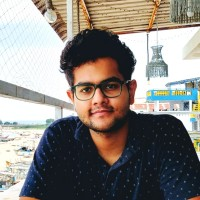